# Keras Mobilenet 版的遷移學習範例 #
請先參考 [貴哥的 colab 初學筆記](https://newtoypia.blogspot.com/2019/07/colab.html) 及 [本範例的背景說明](https://newtoypia.blogspot.com/2019/10/transfer-learning.html)。 本 ipynb 文件修改自 [erhat00/Deep-Learning](https://github.com/ferhat00/Deep-Learning/tree/master/Transfer%20Learning%20CNN)
也大推原作者的 [教學文](https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299)。 

前置作業：
1. 下載 [ckhung/keras-mobilenet](https://github.com/ckhung/keras-mobilenet)， 再上傳到你的 google drive。 假設放在 drive 的 colab/keras-mobilenet/ 目錄底下。
1. 假設你先前已玩過 [google colab](https://newtoypia.blogspot.com/2019/07/colab.html)， 那麼現在從 google drive 裡面打開 km-transfer.ipynb 應該就會自動進入 colab。 (你已做到這一步)
1. 從 colab 的 Edit => Notebook Settings 進去，把 Hardware accelerator 設定成 GPU。
1. 掛載 google drive：

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.chdir('/content/drive/My Drive/colab/keras-mobilenet')
os.listdir('.')

['README.md',
 'LICENSE',
 'dog_behavior.h5',
 'dog_behaviors',
 'quiz',
 'km-transfer.ipynb']

載入相依套件：

In [6]:
%tensorflow_version 1.x 
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image
from keras.optimizers import Adam


建立 MobileNet。 原始論文： [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision
Applications, Howard et al, 2017
](https://arxiv.org/pdf/1704.04861.pdf)


In [7]:
mobile = keras.applications.mobilenet.MobileNet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
17227776/17225924 [==============================] - 0s 0us/step


In [9]:
!ls -l /root/.keras/models
# 剛剛下載的權重矩陣放在這裡


total 16824
-rw-r--r-- 1 root root 17225924 Apr  4 02:03 mobilenet_1_0_224_tf.h5


In [10]:
def prepare_image(image_path, show=True):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    if show:
        display(Image(filename=image_path))
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

def mobile_cl(image_path, show=True):
    prepared = prepare_image(image_path, show)
    ans = mobile.predict(prepared)
    return imagenet_utils.decode_predictions(ans)


先拿現成的類神經網路測試。 以下幾張圖片的狗狗所屬的品種都落在 [1000類標籤](https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json) 當中。 也可以改用 show=False 來阻止畫圖。 

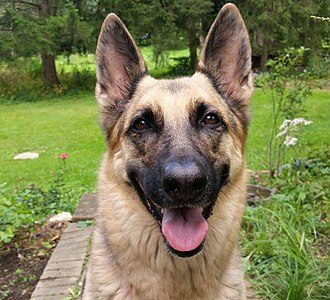


40960/35363 [==================================] - 0s 0us/step


[[('n02106662', 'German_shepherd', 0.9796372),
  ('n02105162', 'malinois', 0.020184083),
  ('n02091467', 'Norwegian_elkhound', 0.00015799515),
  ('n02116738', 'African_hunting_dog', 5.2901587e-06),
  ('n02105251', 'briard', 3.9127376e-06)]]

In [11]:
mobile_cl('quiz/0-german_shepherd.jpg',show=True)

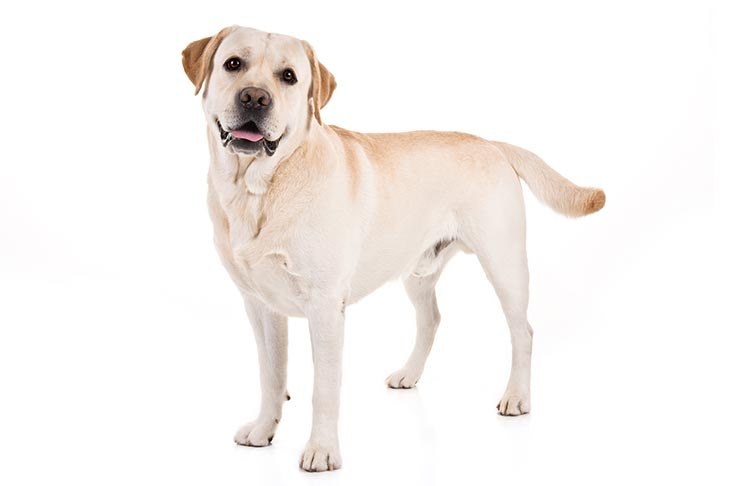

[[('n02099712', 'Labrador_retriever', 0.73073715),
  ('n02087394', 'Rhodesian_ridgeback', 0.03984368),
  ('n02092339', 'Weimaraner', 0.033590093),
  ('n02109047', 'Great_Dane', 0.028944712),
  ('n02110341', 'dalmatian', 0.022403585)]]

In [12]:
mobile_cl('quiz/0-labrador1.jpg',show=True)

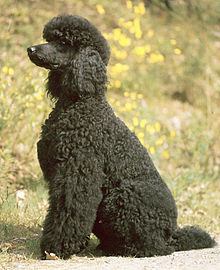

[[('n02113799', 'standard_poodle', 0.56509113),
  ('n02113712', 'miniature_poodle', 0.37279928),
  ('n02102973', 'Irish_water_spaniel', 0.053150624),
  ('n02113624', 'toy_poodle', 0.00721463),
  ('n02093859', 'Kerry_blue_terrier', 0.0013652635)]]

In [13]:
mobile_cl('quiz/0-poodle1.jpg',show=True) 

但是1000類標籤竟然不包含可愛的柴犬！

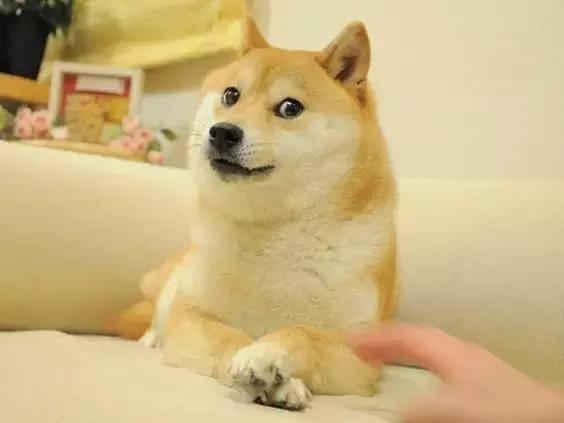

[[('n02113023', 'Pembroke', 0.41327956),
  ('n02110806', 'basenji', 0.35777965),
  ('n02115641', 'dingo', 0.08982951),
  ('n02085620', 'Chihuahua', 0.086097196),
  ('n02113186', 'Cardigan', 0.011335891)]]

In [14]:
mobile_cl('quiz/0-shiba-inu.jpg',show=True) 

以下要拿 MobileNet 來做遷移學習， 改訓練成狗狗動作判別器， 判斷一張圖片當中的狗正在做哪一件事： [其他、 跳、 睡、 游泳、 甩水、 伸展、 尿尿] 。 去除原本的輸出層 (top， 最下游那一層)、 替換成三層 fully connected layers， 以及含有七個 neurons 的新的輸出層。

In [15]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(7,activation='softmax')(x) #final layer with softmax activation
dog_behavior = Model(inputs=base_model.input,outputs=preds)


/tensorflow-1.15.2/python3.7/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 0s 0us/step


In [16]:
!ls -l /root/.keras/models # 這次下載的權重矩陣是 「無頂版」 (no_top)。

total 33684
-rw-r--r-- 1 root root    35363 Apr  4 02:07 imagenet_class_index.json
-rw-r--r-- 1 root root 17225924 Apr  4 02:03 mobilenet_1_0_224_tf.h5
-rw-r--r-- 1 root root 17225924 Apr  4 02:09 mobilenet_1_0_224_tf_no_top.h5


畫圖： 從 [官網文件](https://keras.io/zh/visualization/)  和 [StackOverflow](https://stackoverflow.com/questions/51452569/how-to-resize-rescale-a-svg-graphic-in-an-ipython-jupyter-notebook) 學到如何把模型用 svg 格式畫出來並指定圖形大小。

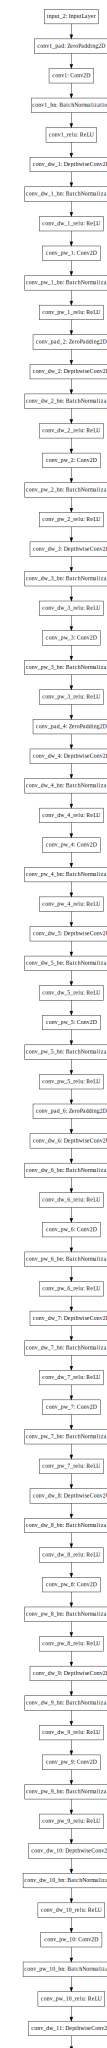

In [17]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model_dot = model_to_dot(dog_behavior)
model_dot.set_size('30')
SVG(model_dot.create(prog='dot', format='svg'))


 畫圖的效果好像不太好， 會被截掉。 算了， 反正結構很單純， 還是直接印文字版好了：

In [18]:
for i,layer in enumerate(dog_behavior.layers):
  print(i,layer.name)

0 input_2
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

鎖住上游大部分的權重(保留既有、訓練好的權重)，只訓練/改變最下游四層的權重。

In [19]:
for layer in dog_behavior.layers:
    layer.trainable=False
for layer in dog_behavior.layers[-4:]:
    layer.trainable=True

[用 google-images-download 下載訓練用的圖片](https://newtoypia.blogspot.com/2019/10/google-images-download.html) ， 把圖片目錄上傳到 drive 的 /colab/dog_behaviors/ 。 我簡化了目錄名稱， 並且在前面加上數字， 比較方便對照。 上述資料備妥之後：

In [22]:
!ls ./dog_behaviors/

0_other  1_jump  2_sleep  3_swim  4_shake  5_stretch  6_pee


把訓練圖片目錄 ./dog_behaviors/ 餵給 ImageDataGenerator：

In [24]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory(
    './dog_behaviors', target_size=(224,224), batch_size=32,
    class_mode='categorical', color_mode='rgb', shuffle=True
)
label2id = train_generator.class_indices
id2label = [label2id[x] for x in label2id]
id2label = dict((v,k) for k,v in label2id.items())

Found 464 images belonging to 7 classes.


編譯完模型之後， 在 google colab 上用 GPU 訓練， 大約五分鐘。

In [25]:
dog_behavior.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
dog_behavior.fit_generator(
    generator=train_generator,
    steps_per_epoch=step_size_train,
    epochs=10
)

Epoch 1/10
14/14 [==============================] - 121s 9s/step - loss: 1.8871 - accuracy: 0.4005
Epoch 2/10
14/14 [==============================] - 14s 1s/step - loss: 0.9454 - accuracy: 0.6829
Epoch 3/10
14/14 [==============================] - 6s 410ms/step - loss: 0.5923 - accuracy: 0.8056
Epoch 4/10
14/14 [==============================] - 6s 414ms/step - loss: 0.3632 - accuracy: 0.8817
Epoch 5/10
14/14 [==============================] - 5s 377ms/step - loss: 0.3330 - accuracy: 0.8822
Epoch 6/10
14/14 [==============================] - 6s 405ms/step - loss: 0.1998 - accuracy: 0.9421
Epoch 7/10
14/14 [==============================] - 6s 410ms/step - loss: 0.1640 - accuracy: 0.9576
Epoch 8/10
14/14 [==============================] - 6s 420ms/step - loss: 0.1121 - accuracy: 0.9606
Epoch 9/10
14/14 [==============================] - 6s 396ms/step - loss: 0.1218 - accuracy: 0.9699
Epoch 10/10
14/14 [==============================] - 6s 407ms/step - loss: 0.1632 - accuracy: 0.9519


測試已訓練好的 dog_behavior 模型

In [26]:
def behavior_cl(image_path, show=True):
    prepared = prepare_image(image_path, show)
    ans = dog_behavior.predict(prepared)[0]
    best = sorted(range(len(ans)), key=lambda k: -ans[k])[:5]
    return ['{:6.2f}% {}'.format(ans[id]*100,id2label[id]) for id in best]


In [27]:
from glob import glob
for f in sorted(glob('quiz/*.jpg')):
    print(f, behavior_cl(f,show=False))

quiz/0-german_shepherd.jpg [' 92.36% 4_shake', '  6.28% 0_other', '  0.58% 3_swim', '  0.27% 6_pee', '  0.25% 1_jump']
quiz/0-labrador1.jpg [' 99.70% 0_other', '  0.11% 5_stretch', '  0.09% 2_sleep', '  0.05% 4_shake', '  0.03% 6_pee']
quiz/0-poodle1.jpg [' 98.17% 4_shake', '  1.61% 0_other', '  0.11% 1_jump', '  0.08% 6_pee', '  0.01% 3_swim']
quiz/0-shiba-inu.jpg [' 98.57% 2_sleep', '  1.38% 0_other', '  0.03% 3_swim', '  0.01% 4_shake', '  0.01% 1_jump']
quiz/jump-1.jpg [' 99.99% 1_jump', '  0.01% 3_swim', '  0.00% 4_shake', '  0.00% 5_stretch', '  0.00% 6_pee']
quiz/jump-2.jpg [' 99.97% 1_jump', '  0.02% 3_swim', '  0.01% 4_shake', '  0.00% 0_other', '  0.00% 5_stretch']
quiz/pee-1.jpg [' 58.00% 4_shake', ' 27.54% 3_swim', '  5.32% 1_jump', '  4.25% 0_other', '  2.55% 6_pee']
quiz/pee-2.jpg [' 51.22% 4_shake', ' 47.20% 6_pee', '  0.79% 0_other', '  0.28% 3_swim', '  0.24% 5_stretch']
quiz/shake-1.jpg ['100.00% 4_shake', '  0.00% 3_swim', '  0.00% 0_other', '  0.00% 2_sleep', '  0.0

In [29]:
dog_behavior.save('./dog_behavior.h5')

In [32]:
!ls -trl . 

total 43943
-rw------- 1 root root      494 Oct 13  2019 README.md
-rw------- 1 root root    35149 Oct 13  2019 LICENSE
drwx------ 9 root root     4096 Nov 28  2019 dog_behaviors
drwx------ 2 root root     4096 Nov 28  2019 quiz
-rw------- 1 root root 44725128 Apr  4 02:36 dog_behavior.h5
-rw------- 1 root root   227478 Apr  4 02:37 km-transfer.ipynb


也請參考： [Keras 儲存與載入訓練好的模型或參數教學](https://blog.gtwang.org/programming/keras-save-and-load-model-tutorial/)